In [86]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import utils_dagma
import networkx as nx

def load_data(n_nodes, seed, version_path):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'{version_path}/W/W_{seed}_0.pkl'), 'rb') as f:
        W = pickle.load(f)
    with open(os.path.join(root_path, f'{version_path}/X/X_1.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_est = W['W_est']
    W = W['W_est'][:, :n_nodes]
    Z = np.abs(W[:n_nodes]) - np.abs(W[n_nodes:])
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    return X, B_true, W_est, W_true

def get_block(data, n_nodes=20, index=11, extract=None):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def get_Z(data, n_nodes=20, left=11, right=21, extract=None):
    left_block = get_block(data, n_nodes, left)
    right_block = get_block(data, n_nodes, right)
    res = np.abs(left_block) - np.abs(right_block)
    
    return res

def get_cutoff(Z11_21):
    fdr_est_last = 1.
    t_last = np.inf
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z11_21)))))
    
    for t in reversed(t_list):
        if t < 0.:
            break
        
        fdr_est = (1 + (Z11_21 <= -t).sum()) / np.max((1, (Z11_21 >= t).sum()))
        
        if fdr_est <= 0.2:
            t_last = t
            fdr_est_last = fdr_est
    return t_last

def draw_strip(n_nodes, ax, version=None, s0=4, only_null=True):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    Z11_21 = get_Z(W_est, n_nodes)
    mask_pos = (Z11_21 > 0.) & (~B_true)
    mask_neg = (Z11_21 < 0.) & (~B_true)
    mask_pos_all = (Z11_21 > 0.)
    mask_neg_all = (Z11_21 < 0.)

    if only_null:
        sns.stripplot([np.abs(Z11_21[mask_pos]), np.abs(Z11_21[mask_neg])], ax=ax)
    else:
        true_label_pos = B_true[mask_pos_all]
        true_label_neg = B_true[mask_neg_all]
        
        data_dict = {
            "|Z|": np.concatenate([
                np.abs(Z11_21[mask_pos_all]),
                np.abs(Z11_21[mask_neg_all])
            ]),
            "category": \
                ['Z > 0'] * mask_pos_all.sum() + \
                ['Z < 0'] * mask_neg_all.sum()
            ,
            "edge_label": np.concatenate([
                true_label_pos,
                true_label_neg
            ])  
        }
        data_dict = pd.DataFrame(data_dict)
        
        # sns.stripplot([np.abs(Z11_21[mask_pos_all]), np.abs(Z11_21[mask_pos_neg])], ax=ax)
        sns.stripplot(data_dict, x="category", y='|Z|', hue="edge_label", ax=ax, alpha=0.7)
    cutoff = get_cutoff(Z11_21)
    ax.axhline(y=cutoff, color='red', linestyle='--')
    ax.set_xticks([0, 1], ["Z > 0", "Z < 0"])
    if only_null:
        ax.set_ylabel("|Z| of null edges")
    else:
        ax.set_ylabel("|Z| of all edges")
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def draw_ecdf(n_nodes, ax, log=False, version=None, s0=4):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    W11, W21 = get_block(W_est, n_nodes, index=11), get_block(W_est, n_nodes, index=21)
    if log:
        sns.ecdfplot(np.log(np.abs(W11[~B_true])+1e-8).flatten(), ax=ax, label="log|W11| null")
        sns.ecdfplot(np.log(np.abs(W21[~B_true])+1e-8).flatten(), ax=ax, label="log|W21| null")
    else:
        sns.ecdfplot(np.abs(W11[~B_true]).flatten(), ax=ax, label="|W11| null")
        sns.ecdfplot(np.abs(W21[~B_true]).flatten(), ax=ax, label="|W21| null")
    ax.set_ylim([0., 1.1])
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, alpha, notes, use_strip=False):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"
    
    
    if use_out_deg:
        deg_list = out_deg
        deg_str = "out-degree"
    else:
        deg_list = in_deg
        deg_str = "in-degree"
    deg_uni = np.unique(deg_list)

    data_dict = {
        "deg": [],
        "Z": [],
        "label": []
    }
    
    for deg in deg_uni:
        _n_mask = np.where(deg_list == deg)[0]
        n_mask = np.full(len(deg_list), fill_value=False)
        n_mask[_n_mask] = True
        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    sns.boxplot(df, x='deg', y='Z', hue='label', ax=ax, fill=False)
    if use_strip:
        sns.stripplot(df, x='deg', y='Z', hue='label', ax=ax, alpha=alpha, dodge=True)
    # sns.boxplot(df.loc[df['label'] == 'null edges', :], x='deg', y='Z', hue='label', ax=ax[1])
    # if use_strip:
    #     sns.stripplot(df.loc[df['label'] == 'null edges', :], x='deg', y='Z', hue='label', ax=ax[1], alpha=0.7)
    ax.set_title(f'Z vs {deg_str} of {src_str} nodes | {len(Z11_21)} nodes | {4 * len(Z11_21)} edges | seed 1 | {notes}')
    return df

def z0_vs_depth_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_strip=False, alpha=0.5):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"

    data_dict = {
        "min_depth": [],
        "Z": [],
        "label": []
    }
    
    G = nx.DiGraph(B_true.astype(int))
    start_nodes = np.where(B_true.sum(axis=0) == 0)[0]
    
    min_depth = {}
    for n in G.nodes:
        depth = []
        _depth = dict(nx.single_target_shortest_path_length(G, target=n))
        for st_n in start_nodes:
            depth.append(_depth.get(st_n, np.inf))
        depth = np.array(depth)
        min_depth[n] = depth.min()

    min_depth_uni = np.unique(list(min_depth.values()))
    for min_d in min_depth_uni:
        _n_mask = np.where(
            np.array(list(min_depth.values())) == min_d
        )[0]
        n_mask = np.full(len(B_true), fill_value=False)
        n_mask[_n_mask] = True

        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
        
        data_dict['Z'].extend(_data)
        data_dict['min_depth'].extend([min_d] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['min_depth'].extend([min_d] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    sns.boxplot(df, x='min_depth', y='Z', hue='label', ax=ax, fill=False)
    if use_strip:
        sns.stripplot(df, x='min_depth', y='Z', hue='label', ax=ax, alpha=alpha, dodge=True)
    ax.set_title(f'knockoff statistics Z vs min depth of {src_str} nodes | {len(Z11_21)} nodes | {4 * len(Z11_21)} edges | seed 1')
    ax.set_xlabel("for each node, min depth from it to all starting nodes")
    ax.set_ylabel("knockoff statistics of edges out of source nodes")
    return df

def sys_z0_vs_depth_box(n_nodes, data_version, seed, alpha=0.5, use_strip=True):
    n_nodes = n_nodes
    X, B_true, W_est, W_true = load_data(n_nodes, seed, f"v{data_version}/v{n_nodes}")
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)

    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    df = z0_vs_depth_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_strip=use_strip, alpha=alpha)
    return df

def sys_z0_vs_deg_box(n_nodes, exp, data_version, alpha=0.5, use_strip=True, notes=None):
    if data_version == '42':
        X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v42/v{exp}/v{n_nodes}_{n_nodes * 4}_1")
    else:
        X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v{data_version}/v{n_nodes}")
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)
    
    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    src = True
    use_out_deg = False
    df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, use_strip=use_strip, alpha=alpha, notes=notes)

    return df, B_true

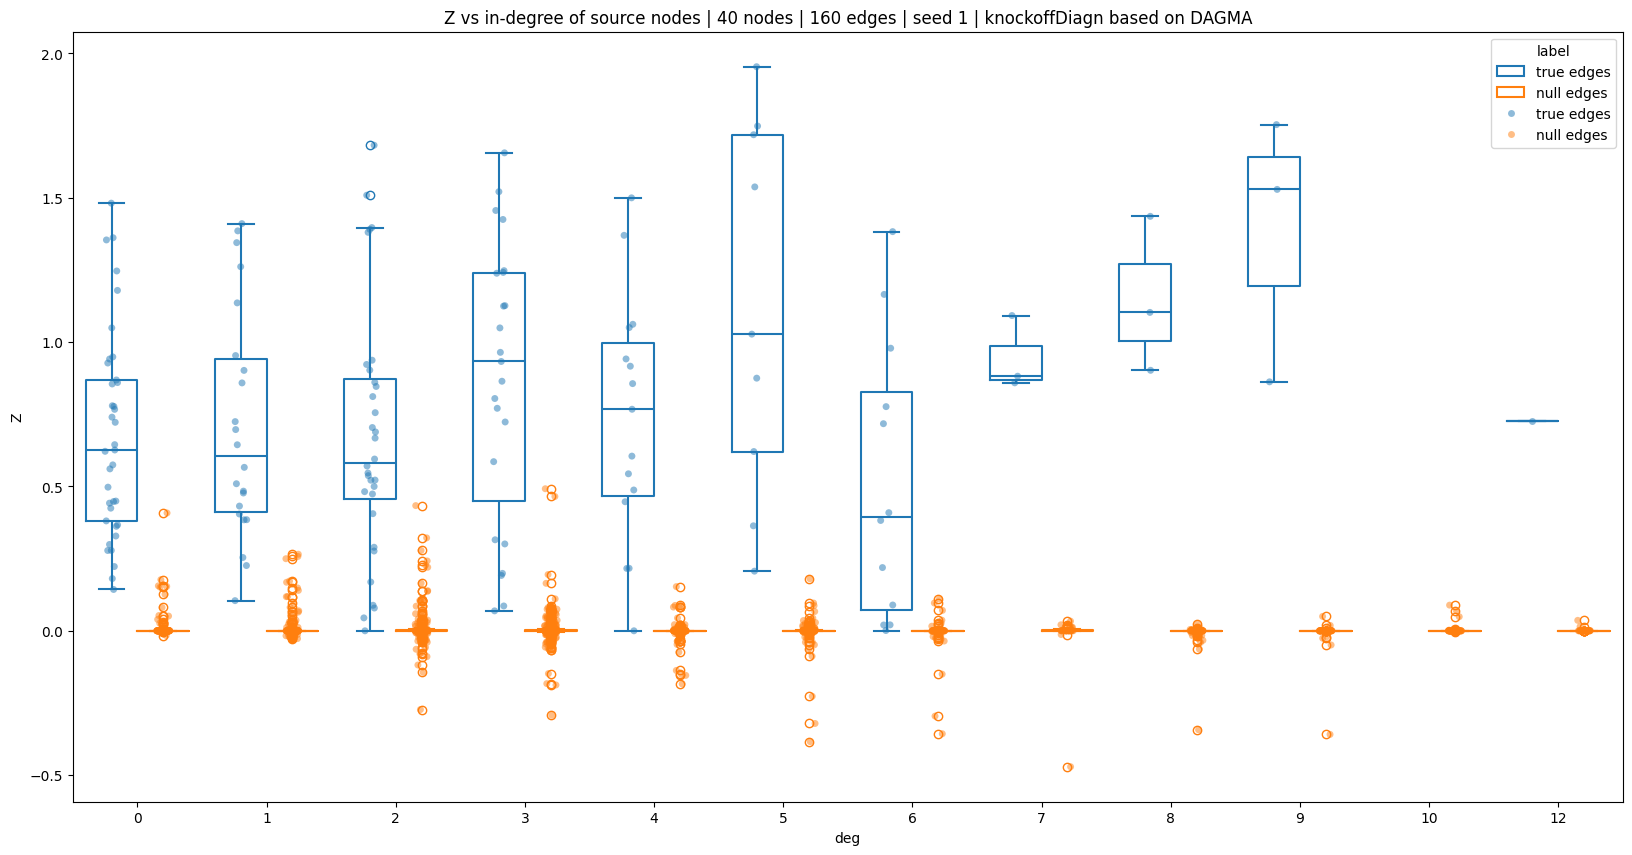

In [61]:
n_nodes = 40
data_version = '34'
df = sys_z0_vs_deg_box(n_nodes, exp, data_version, notes='knockoffDiagn based on DAGMA')

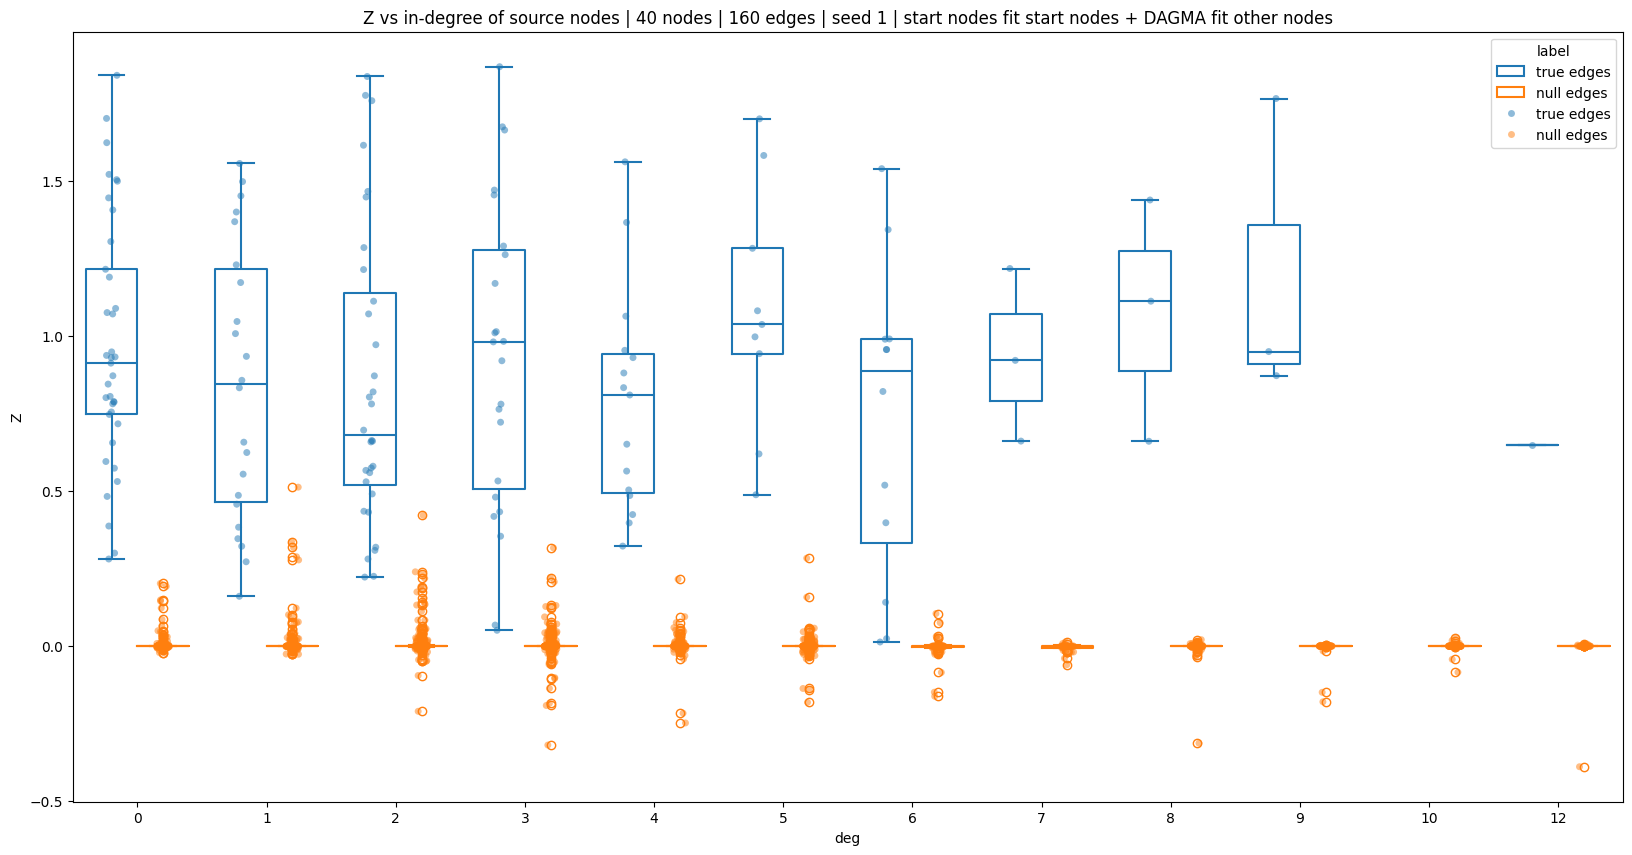

In [87]:
n_nodes = 40
exp = "1_1"
data_version = '42'
df, B_true = sys_z0_vs_deg_box(n_nodes, exp, data_version, notes='start nodes fit start nodes + DAGMA fit other nodes')

In [88]:
n_nodes = 40
data_dir = "/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
version = f"v39/W_{n_nodes}_{n_nodes * 4}_{1}.pkl"
data_path = os.path.join(data_dir, version)
with open(data_path, 'rb') as f:
    W_est = pickle.load(f)
mask = utils.extract_dag_mask(np.abs(W_est), 0)
W_est[~mask] = 0.
G = nx.DiGraph(W_est)
in_deg = G.in_degree()
in_deg_true = B_true.sum(axis=0)
assert nx.is_directed_acyclic_graph(G)

In [82]:
start_n = [i for i in range(G.number_of_nodes()) if in_deg[i] == 0]

In [83]:
start_n

[3, 24, 30, 33]

In [89]:
np.where(in_deg_true == 0)[0]

array([ 3,  8, 24, 30, 33])

In [85]:
def _get_non_desc(G: nx.DiGraph, i: int):
    node_set = set(G.nodes())
    i_desc_set = nx.descendants(G, i)
    remained_n = node_set.difference(i_desc_set)
    remained_n.remove(i)
    remained_n = list(remained_n)

    return remained_n
[len(_get_non_desc(G, i)) for i in start_n]

[11, 3, 14, 16]

In [90]:
[len(_get_non_desc(G, i)) for i in np.where(in_deg_true == 0)[0]]

[11, 7, 3, 14, 16]

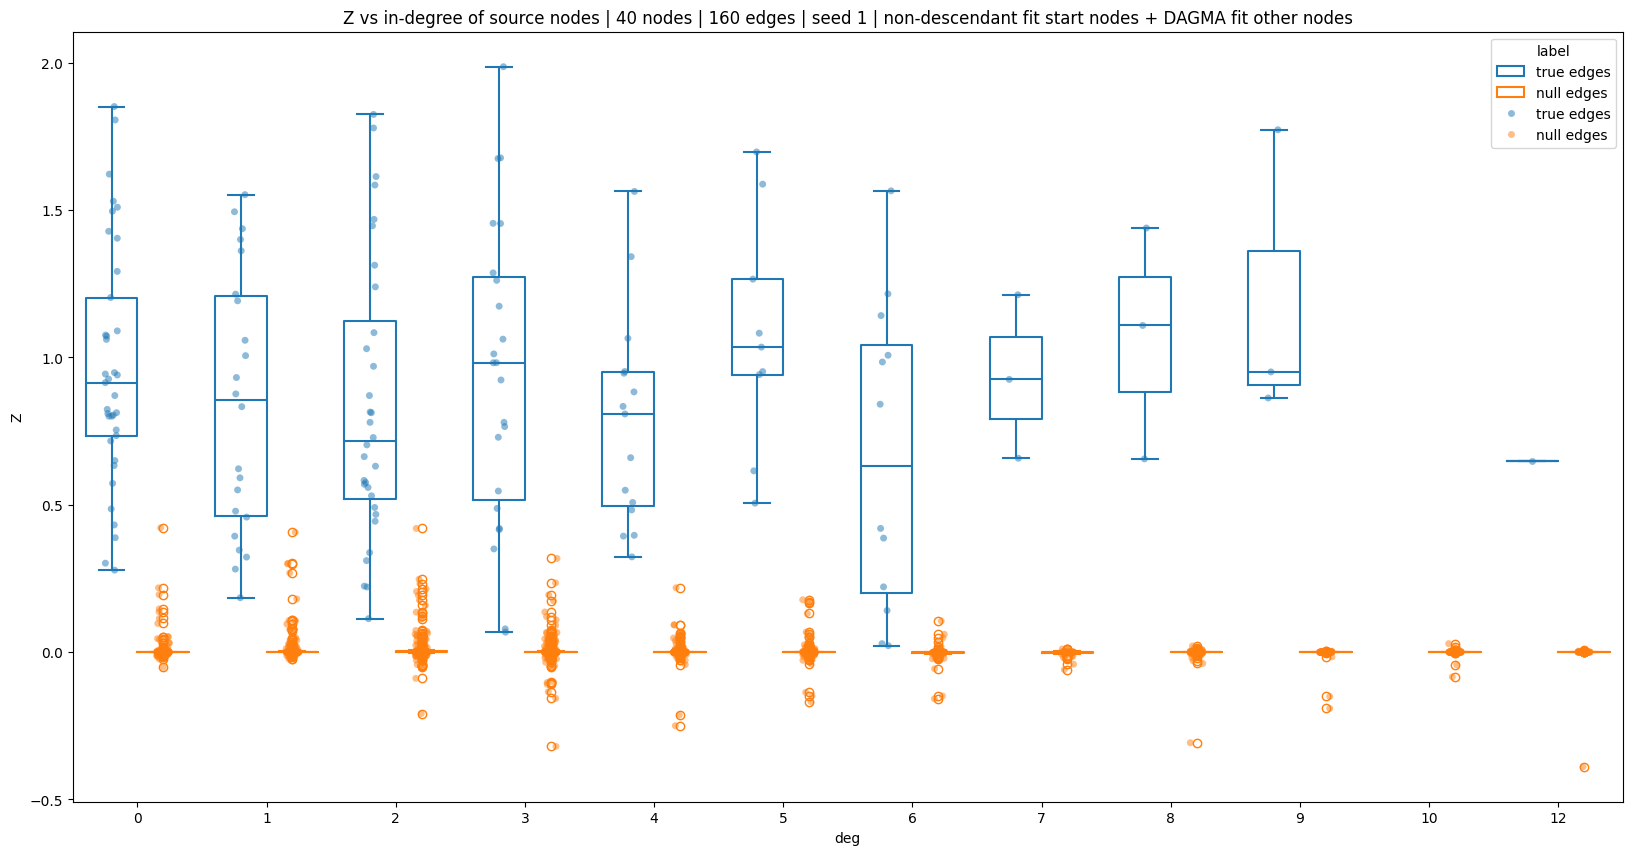

In [52]:
n_nodes = 40
exp = "2_1"
data_version = '42'
df = sys_z0_vs_deg_box(n_nodes, exp, data_version, notes='non-descendant fit start nodes + DAGMA fit other nodes')